## 1. Importación de librerías y configuración inicial


In [2]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Librerías para procesamiento de imágenes
from skimage import io, color, feature, measure, filters
from skimage.transform import resize
import cv2

# Librerías para preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Librerías para reducción de dimensionalidad y selección de características
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, SelectFromModel

# Librerías para modelos de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Librerías para evaluación de modelos
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para medición de rendimiento computacional
import time
import psutil
from memory_profiler import profile

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 2. Carga y exploración inicial del dataset


Cargando archivo metadata...
Forma del dataset: (2298, 26)
Columnas disponibles: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed']

Primeras 5 filas:
  patient_id  lesion_id  smoke  drink background_father background_mother  \
0   PAT_1516       1765    NaN    NaN               NaN               NaN   
1     PAT_46        881  False  False         POMERANIA         POMERANIA   
2   PAT_1545       1867    NaN    NaN               NaN               NaN   
3   PAT_1989       4061    NaN    NaN               NaN               NaN   
4    PAT_684       1302  False   True         POMERANIA         POMERANIA   

   age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
0    8       NaN  

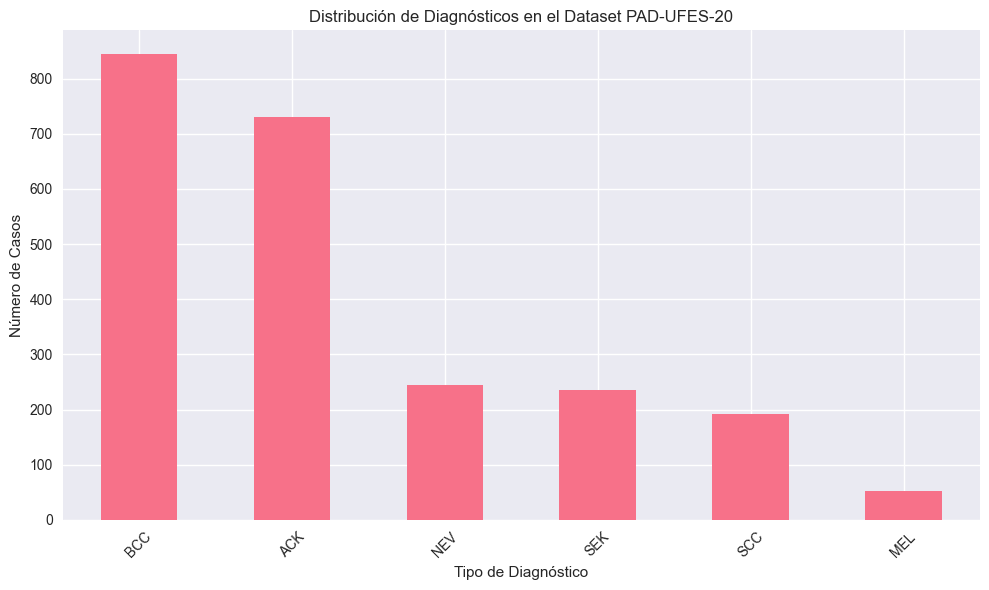

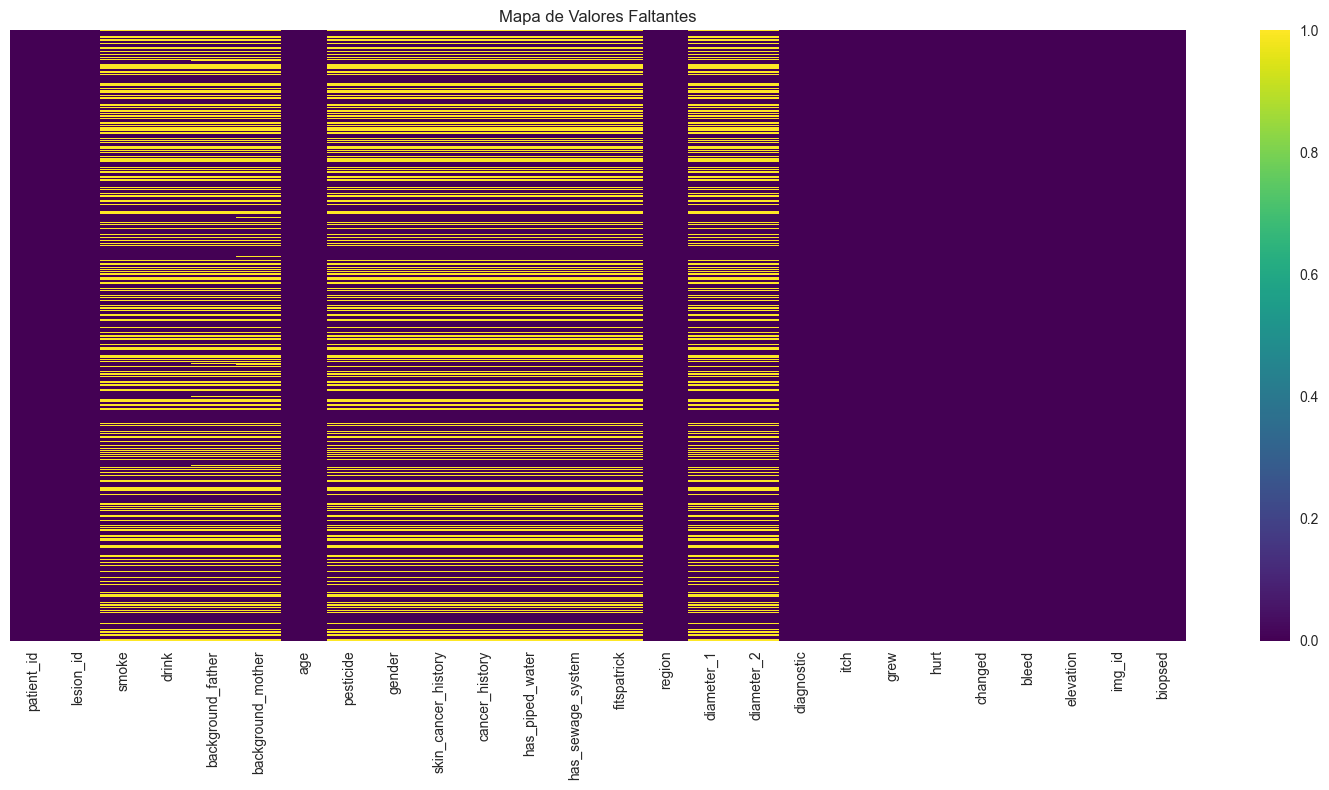

In [3]:
# Definir rutas de archivos
METADATA_PATH = "zr7vgbcyr2-1\metadata.csv"  # Cambia por tu ruta real
IMAGES_PATH = "zr7vgbcyr2-1\images\imgs/"  # Cambia por tu ruta real

# Cargar el archivo metadata
print("Cargando archivo metadata...")
df = pd.read_csv(METADATA_PATH)

# Exploración inicial del dataset
print(f"Forma del dataset: {df.shape}")
print(f"Columnas disponibles: {list(df.columns)}")
print("\nPrimeras 5 filas:")
print(df.head())

# Análisis de valores faltantes
print("\nValores faltantes por columna:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
}).sort_values('Porcentaje', ascending=False)
print(missing_df)

# Análisis de distribución de clases (diagnósticos)
print("\nDistribución de diagnósticos:")
diagnosis_counts = df['diagnostic'].value_counts()
print(diagnosis_counts)
print(df.isnull().sum())

# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
diagnosis_counts.plot(kind='bar')
plt.title('Distribución de Diagnósticos en el Dataset PAD-UFES-20')
plt.xlabel('Tipo de Diagnóstico')
plt.ylabel('Número de Casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_diagnosticos.png', dpi=300, bbox_inches='tight')
plt.show()

# Mapa de calor de valores faltantes
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Mapa de Valores Faltantes')
plt.tight_layout()
plt.savefig('mapa_valores_faltantes.png', dpi=300, bbox_inches='tight')
plt.show()


Qué se hizo
1. Se cargó el archivo de datos.
2. Se revisó su forma: tiene 2298 filas (pacientes o lesiones) y 26 columnas (información sobre cada caso).
3. Se imprimieron las primeras 5 filas para ver un ejemplo.
4. Se analizó si hay datos faltantes (campos vacíos).
5. Se vio cuántos casos hay por cada tipo de diagnóstico.

Qué se descubrió
1. Hay muchos datos faltantes
- 804 filas tienen información vacía en varias columnas importantes como:
- Si fuma o toma alcohol
- Si usó pesticidas
- El sexo del paciente
- Antecedentes familiares
- Tamaño de la lesión
- Tipo de piel (fitzpatrick)
significa que en esos 804 casos, faltan muchos datos importantes, no solo uno.

2. Otras columnas están completas
- Aun así, algunas columnas no tienen vacíos:
- Edad, región, diagnóstico,
- Síntomas: picor, si creció, si cambió, si sangra, etc.
- El nombre de la imagen (img_id)
- Si fue biopsiado (biopsed)

3. Hay un problema de desbalance
- El número de casos por tipo de lesión no está equilibrado:
- Hay muchos de tipo BCC y ACK
- Muy pocos de tipo MEL (melanoma), que es el más peligroso
- Esto puede causar problemas si entrenas un modelo, porque va a aprender más de las clases comunes y a ignorar las raras.




## 3. Preprocesamiento de datos clínicos

In [5]:
def preprocess_clinical_data(df):
    """
    Preprocesa los datos clínicos del dataset PAD-UFES-20
    
    Args:
        df: DataFrame con los datos originales
    
    Returns:
        X_clinical: Características clínicas preprocesadas
        y: Etiquetas de diagnóstico
        feature_names: Nombres de las características
        label_encoder: Codificador de etiquetas para poder decodificar después
    """
    
    # Crear una copia del dataframe para no modificar el original
    df_processed = df.copy()
    
    # Separar características y etiquetas
    # Excluimos columnas que no son características útiles para el modelo
    columns_to_exclude = ['patient_id', 'lesion_id', 'img_id', 'diagnostic']
    X_clinical = df_processed.drop(columns=columns_to_exclude)
    y = df_processed['diagnostic']
    
    # Codificar las etiquetas de diagnóstico
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"Clases codificadas: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
    
    # Identificar tipos de columnas para aplicar preprocesamiento específico
    # Columnas numéricas: edad, diámetros, fitzpatrick
    numeric_features = ['age', 'diameter_1', 'diameter_2', 'fitspatrick']
    
    # Columnas categóricas: todas las demás
    categorical_features = [col for col in X_clinical.columns if col not in numeric_features]
    
    print(f"Características numéricas: {numeric_features}")
    print(f"Características categóricas: {categorical_features}")
    
    # Pipeline para características numéricas
    # 1. Imputar valores faltantes con la mediana (más robusto que la media)
    # 2. Estandarizar (media=0, desviación=1)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Pipeline para características categóricas
    # 1. Imputar valores faltantes con la moda (valor más frecuente)
    # 2. Codificación one-hot (crear variables dummy)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combinar ambos transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Aplicar el preprocesamiento
    print("Aplicando preprocesamiento a datos clínicos...")
    X_clinical_processed = preprocessor.fit_transform(X_clinical)
    
    # Obtener nombres de características después del preprocesamiento
    # Para características numéricas, los nombres se mantienen
    numeric_feature_names = numeric_features
    
    # Para características categóricas, se crean nuevos nombres con one-hot encoding
    categorical_feature_names = []
    if hasattr(preprocessor.named_transformers_['cat']['onehot'], 'get_feature_names_out'):
        categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    else:
        # Para versiones más antiguas de sklearn
        categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_features)
    
    # Combinar todos los nombres de características
    feature_names = list(numeric_feature_names) + list(categorical_feature_names)
    
    print(f"Forma de datos clínicos procesados: {X_clinical_processed.shape}")
    print(f"Número total de características: {len(feature_names)}")
    
    return X_clinical_processed, y_encoded, feature_names, label_encoder, preprocessor

# Aplicar preprocesamiento
X_clinical, y, clinical_feature_names, label_encoder, clinical_preprocessor = preprocess_clinical_data(df)


Clases codificadas: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}
Características numéricas: ['age', 'diameter_1', 'diameter_2', 'fitspatrick']
Características categóricas: ['smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'region', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']
Aplicando preprocesamiento a datos clínicos...
Forma de datos clínicos procesados: (2298, 78)
Número total de características: 78


Se creó la función para preparar los datos clínicos del dataset para poder ser usado en los modelos machine learning

Que se hizo exactamente?

1. Se separó lo que no era util y lo que no
- Eliminando columnas que no son útiles como entrada para el modelo
- dejando solo las características clínicas para entrenar (X_clinical) y guardar las etiquetas (y=diagnostic)

2. Codificar los diagnósticos
- Se convirtieron los de los diagnósticos en números para que los modelos lo entiendan

3. Detectar tipos de variables
- Númericas: edad, diámetro 1 y 2 de la lesión, tipo de piel
- Categóricas: todas las demás (ej: si fuma, si sangra, región, etc)

4. Preprocesamiento de cada tipo de variable
Numéricas:
- Si hay datos faltantes, los rellana con la media
- Luego los normaliza para que tenga media 0 y desviación estándar 1
Categóricas:
- Si hay valores faltantes, los rellena con la moda
- Luego se convierte en variable numéricas con One-Hot Encoding

5. Aplica todo el preprocesamiento
- Usa ColumnTransformer para aplicar los dos tipos de transformaciones al mismo tiempo.
- Lo aplica a todo el conjunto y obtiene los datos ya listos para entrenar un modelo.

6. Resultado
Despues del procesar todo:
Entrada final (X_clinical_processed) tiene forma (2298, 78), es decir:
- 2298 pacientes
- 78 columnas (características finales después de convertir texto en números)

Imprime cuántas características resultaron (78)
Devuelve:
- X_clinical: los datos ya listos para modelos
- y: los diagnósticos convertidos a números
- feature_names: nombres de las 78 columnas
- label_encoder: para poder volver de número a nombre de diagnóstico
- preprocessor: el transformador completo que puedes usar más adelante

¿Qué salió al final?
- Diagnósticos codificados: 'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5
- Variables numéricas: ['age', 'diameter_1', 'diameter_2', 'fitspatrick']
- Variables categóricas: 18 columnas
- Total de columnas finales después del procesamiento: 78 (por el One-Hot Encoding que genera columnas nuevas para cada categoría)


En resumen
Este código:
- Limpia, completa y transforma los datos clínicos
- Convierte texto en números
- Deja todo listo para entrenar un modelo
- Da como resultado un conjunto de 2298 filas y 78 columnas completamente numéricas y sin valores vacíos

## 4. Extracción de características de imágenes

In [6]:
def extract_image_features(image_path, target_size=(224, 224)):
    try:
        img = io.imread(image_path)

        # Convertir a RGB si tiene 4 canales (RGBA)
        if img.shape[-1] == 4:
            img = img[:, :, :3]

        # Redimensionar
        img_resized = resize(img, target_size, anti_aliasing=True)

        # Escala de grises
        if len(img_resized.shape) > 2 and img_resized.shape[2] > 1:
            img_gray = color.rgb2gray(img_resized)
        else:
            img_gray = img_resized

        features = {}

        # ==== CARACTERÍSTICAS DE COLOR ====
        if len(img_resized.shape) > 2 and img_resized.shape[2] >= 3:
            for i, channel in enumerate(['R', 'G', 'B']):
                channel_data = img_resized[:, :, i]
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_skew'] = np.mean((channel_data - np.mean(channel_data))**3) / (np.std(channel_data)**3 + 1e-8)
                features[f'{channel}_kurtosis'] = np.mean((channel_data - np.mean(channel_data))**4) / (np.std(channel_data)**4 + 1e-8)

            for i, channel in enumerate(['R', 'G', 'B']):
                hist, _ = np.histogram(img_resized[:, :, i], bins=20, range=[0, 1])
                for j, h in enumerate(hist):
                    features[f'{channel}_hist_{j}'] = h

        # ==== CARACTERÍSTICAS DE TEXTURA ====
        # Escalar correctamente a niveles GLCM
        img_gray_int = (img_gray * 15).clip(0, 15).astype(np.uint8)  # para levels=16

        distances = [1, 2]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

        for distance in distances:
            glcm = feature.graycomatrix(
                img_gray_int,
                distances=[distance],
                angles=angles,
                levels=16,
                symmetric=True,
                normed=True
            )
            features[f'contrast_d{distance}'] = np.mean(feature.graycoprops(glcm, 'contrast'))
            features[f'dissimilarity_d{distance}'] = np.mean(feature.graycoprops(glcm, 'dissimilarity'))
            features[f'homogeneity_d{distance}'] = np.mean(feature.graycoprops(glcm, 'homogeneity'))
            features[f'energy_d{distance}'] = np.mean(feature.graycoprops(glcm, 'energy'))
            features[f'correlation_d{distance}'] = np.mean(feature.graycoprops(glcm, 'correlation'))

        # LBP
        radius = 3
        n_points = 8 * radius
        lbp = feature.local_binary_pattern(img_gray, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
        for i, h in enumerate(lbp_hist):
            features[f'lbp_hist_{i}'] = h

        # ==== ESTADÍSTICAS BÁSICAS ====
        features['mean_intensity'] = np.mean(img_gray)
        features['std_intensity'] = np.std(img_gray)
        features['min_intensity'] = np.min(img_gray)
        features['max_intensity'] = np.max(img_gray)
        features['median_intensity'] = np.median(img_gray)
        features['range_intensity'] = np.max(img_gray) - np.min(img_gray)
        features['percentile_25'] = np.percentile(img_gray, 25)
        features['percentile_75'] = np.percentile(img_gray, 75)
        features['iqr'] = features['percentile_75'] - features['percentile_25']

        # ==== BORDES Y GRADIENTES ====
        edges = feature.canny(img_gray, sigma=1.0)
        features['edge_density'] = np.sum(edges) / edges.size

        grad_x = filters.sobel_h(img_gray)
        grad_y = filters.sobel_v(img_gray)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        features['gradient_mean'] = np.mean(gradient_magnitude)
        features['gradient_std'] = np.std(gradient_magnitude)
        features['gradient_max'] = np.max(gradient_magnitude)

        return features

    except Exception as e:
        print(f"Error procesando imagen {image_path}: {e}")
        return None


def extract_all_image_features(df, images_path):
    """
    Extrae características de todas las imágenes en el dataset
    
    Args:
        df: DataFrame con metadata
        images_path: Ruta a la carpeta de imágenes
    
    Returns:
        image_features_df: DataFrame con características de imágenes
    """
    
    print("Iniciando extracción de características de imágenes...")
    print(f"Procesando {len(df)} imágenes...")
    
    image_features = {}
    processed_count = 0
    error_count = 0
    
    for index, row in df.iterrows():
        img_id = row['img_id']
        img_path = os.path.join(images_path, img_id)
        
        # Verificar si la imagen existe
        if os.path.exists(img_path):
            features = extract_image_features(img_path)
            if features is not None:
                image_features[img_id] = features
                processed_count += 1
            else:
                error_count += 1
        else:
            print(f"Imagen no encontrada: {img_path}")
            error_count += 1
        
        # Mostrar progreso cada 100 imágenes
        if (processed_count + error_count) % 100 == 0:
            print(f"Procesadas: {processed_count}, Errores: {error_count}")
    
    print(f"Extracción completada. Procesadas: {processed_count}, Errores: {error_count}")
    
    # Convertir a DataFrame
    image_features_df = pd.DataFrame.from_dict(image_features, orient='index')
    image_features_df.index.name = 'img_id'
    image_features_df = image_features_df.reset_index()
    
    print(f"Forma del DataFrame de características de imágenes: {image_features_df.shape}")
    
    return image_features_df

# Extraer características de todas las imágenes
# NOTA: Cambia IMAGES_PATH por la ruta real de tus imágenes
image_features_df = extract_all_image_features(df, IMAGES_PATH)

# Guardar las características extraídas para uso futuro
image_features_df.to_csv('image_features.csv', index=False)
print("Características de imágenes guardadas en 'image_features.csv'")


Iniciando extracción de características de imágenes...
Procesando 2298 imágenes...
Procesadas: 100, Errores: 0
Procesadas: 200, Errores: 0
Procesadas: 300, Errores: 0
Procesadas: 400, Errores: 0
Procesadas: 500, Errores: 0
Procesadas: 600, Errores: 0
Procesadas: 700, Errores: 0
Procesadas: 800, Errores: 0
Procesadas: 900, Errores: 0
Procesadas: 1000, Errores: 0
Procesadas: 1100, Errores: 0
Procesadas: 1200, Errores: 0
Procesadas: 1300, Errores: 0
Procesadas: 1400, Errores: 0
Procesadas: 1500, Errores: 0
Procesadas: 1600, Errores: 0
Procesadas: 1700, Errores: 0
Procesadas: 1800, Errores: 0
Procesadas: 1900, Errores: 0
Procesadas: 2000, Errores: 0
Procesadas: 2100, Errores: 0
Procesadas: 2200, Errores: 0
Extracción completada. Procesadas: 2298, Errores: 0
Forma del DataFrame de características de imágenes: (2298, 122)
Características de imágenes guardadas en 'image_features.csv'


Objetivo
Convertir cada imagen del dataset PAD-UFES-20 en un conjunto de características numéricas que describen su contenido visual: color, textura, intensidad y bordes.
Esto permite que un modelo de machine learning pueda trabajar con las imágenes sin necesidad de redes convolucionales, usando directamente vectores numéricos.

🔧 ¿Qué se hizo exactamente?

1. Carga y preprocesamiento de la imagen
- Se leyó la imagen desde disco (io.imread).
- Si tenía 4 canales (RGB + alpha), se eliminó el canal alpha.
- Se redimensionó a un tamaño fijo de 224x224 píxeles.
- Se convirtió a escala de grises (necesario para extraer textura y bordes).

2. 🟥 Características de color (12 + 60 = 72)

Por cada canal R, G y B se extrajeron:

a) Estadísticas (4 por canal):
- mean: Promedio de intensidad (brillo del color)
- std: Desviación estándar (variación del color)
- skew: Asimetría de la distribución de colores (forma de la curva)
- kurtosis: Concentración de valores extremos (cuán "picuda" es la curva)
➡️ Total: 3 canales × 4 métricas = 12 características

b) Histogramas (20 bins por canal):
- Cuánto contenido de cada nivel de color hay en la imagen (dividido en 20 rangos de valores)
➡️ Total: 3 canales × 20 bins = 60 características

3. 🟫 Características de textura - GLCM (10)
- Se generaron matrices de co-ocurrencia (GLCM) a distintos ángulos y distancias.
- Se midieron propiedades clásicas de textura:
  contrast, dissimilarity, homogeneity, energy, correlation
- Se promediaron los resultados en los 4 ángulos, para dos distancias: 1 y 2 píxeles
➡️ Total: 5 métricas × 2 distancias = 10 características

4. ⚪ Textura local - LBP (Local Binary Pattern) (26)
- Se aplicó LBP (método que analiza las diferencias de brillo entre un píxel y sus vecinos).
- Se extrajo un histograma de frecuencias de cada patrón detectado.
➡️ Histograma con 8*3 + 2 = 26 bins → 26 características

5. ⚫ Estadísticas de intensidad en escala de grises (9)
- mean_intensity, std_intensity, min, max, median
- range (max - min)
- percentile_25, percentile_75, iqr (diferencia entre percentiles)
➡️ Total: 9 características

6. ⚡ Bordes y gradientes (4)
- Detección de bordes con Canny → edge_density
- Cálculo de gradientes (sobel horizontal y vertical):
  gradient_mean, gradient_std, gradient_max
➡️ Total: 4 características

📊 Resultado
- Se procesaron 2298 imágenes sin errores.
- Se extrajo un total de 122 características por imagen.
- El resultado fue un DataFrame con:
  Forma: (2298, 122)
- Se guardó como archivo:
  image_features.csv

✅ Conclusión
Esta etapa convirtió imágenes en vectores numéricos útiles para modelos clásicos (como SVM, Random Forest, etc.), sin necesidad de usar redes neuronales profundas.

Las características cubren:
📈 Estadísticas de color
🧵 Texturas y patrones locales
🔆 Intensidad de luz
🔲 Bordes y cambios bruscos de color


## 5. Creación del dataset multimodal


In [7]:
def create_multimodal_dataset(df, image_features_df, X_clinical, clinical_feature_names):
    """
    Combina características de imágenes con datos clínicos para crear dataset multimodal
    
    Args:
        df: DataFrame original con metadata
        image_features_df: DataFrame con características de imágenes
        X_clinical: Array con datos clínicos preprocesados
        clinical_feature_names: Nombres de características clínicas
    
    Returns:
        X_multimodal: Dataset multimodal combinado
        multimodal_feature_names: Nombres de todas las características
    """
    
    print("Creando dataset multimodal...")
    
    # Unir características de imágenes con el DataFrame original
    df_with_images = pd.merge(df, image_features_df, on='img_id', how='inner')
    
    print(f"Casos con imágenes procesadas: {len(df_with_images)}")
    
    # Extraer solo las características de imágenes (excluir img_id)
    image_feature_columns = [col for col in image_features_df.columns if col != 'img_id']
    X_image_features = df_with_images[image_feature_columns].values
    
    # Asegurar que tenemos el mismo número de filas en datos clínicos e imágenes
    # Filtrar datos clínicos para que coincidan con las imágenes procesadas
    valid_indices = df['img_id'].isin(df_with_images['img_id'])
    X_clinical_filtered = X_clinical[valid_indices]
    
    print(f"Forma de características clínicas filtradas: {X_clinical_filtered.shape}")
    print(f"Forma de características de imágenes: {X_image_features.shape}")
    
    # Combinar características de imágenes y clínicas
    X_multimodal = np.hstack([X_clinical_filtered, X_image_features])
    
    # Combinar nombres de características
    multimodal_feature_names = clinical_feature_names + image_feature_columns
    
    print(f"Forma del dataset multimodal: {X_multimodal.shape}")
    print(f"Número total de características: {len(multimodal_feature_names)}")
    
    return X_multimodal, multimodal_feature_names, valid_indices

# Crear dataset multimodal
X_multimodal, multimodal_feature_names, valid_indices = create_multimodal_dataset(
    df, image_features_df, X_clinical, clinical_feature_names
)

# Filtrar las etiquetas para que coincidan con los datos multimodales
y_multimodal = y[valid_indices]

print(f"Forma final del dataset multimodal: {X_multimodal.shape}")
print(f"Número de etiquetas: {len(y_multimodal)}")


Creando dataset multimodal...
Casos con imágenes procesadas: 2298
Forma de características clínicas filtradas: (2298, 78)
Forma de características de imágenes: (2298, 121)
Forma del dataset multimodal: (2298, 199)
Número total de características: 199
Forma final del dataset multimodal: (2298, 199)
Número de etiquetas: 2298


🧠 Objetivo general
Construir un dataset multimodal, combinando:

🔹 Datos clínicos preprocesados (X_clinical) — 78 columnas  
🔹 Características de imágenes (image_features_df) — 121 columnas

Para poder usar ambos tipos de información al mismo tiempo en un modelo de clasificación.

🔧 Paso a paso con detalle

1. 🔗 Unión de dataframes

df_with_images = pd.merge(df, image_features_df, on='img_id', how='inner')

- Une la metadata original df con el dataframe que tiene las características de imágenes.
- Lo hace usando la columna 'img_id' como clave.
- how='inner' asegura que solo se conservan los casos que tienen imagen procesada.

📌 Resultado:
Se conservaron 2298 registros, es decir, todas las imágenes tienen datos clínicos y visuales.

2. 🧱 Separación de las características de imagen

image_feature_columns = [col for col in image_features_df.columns if col != 'img_id']
X_image_features = df_with_images[image_feature_columns].values

- Se eliminó la columna img_id y se extrajeron las columnas numéricas generadas en la etapa anterior (color, textura, bordes, etc.)
- Quedan 121 columnas por imagen.

📌 Resultado:
X_image_features tiene forma (2298, 121)

3. 🧼 Filtrado de datos clínicos

valid_indices = df['img_id'].isin(df_with_images['img_id'])
X_clinical_filtered = X_clinical[valid_indices]

- Asegura que las filas de los datos clínicos (X_clinical) coincidan en orden y cantidad con las imágenes procesadas.
- Filtra usando img_id.

📌 Resultado:
X_clinical_filtered tiene forma (2298, 78)

4. 🧬 Fusión de modalidades

X_multimodal = np.hstack([X_clinical_filtered, X_image_features])

- Une horizontalmente los datos clínicos y de imagen.
- Se combinan 78 + 121 = 199 columnas.

📌 Resultado:
X_multimodal tiene forma (2298, 199)

5. 🏷️ Filtrado de etiquetas

y_multimodal = y[valid_indices]

- Las etiquetas (y, que indica el tipo de lesión) se filtran para que coincidan exactamente con las filas del dataset multimodal.

📌 Resultado:
y_multimodal tiene 2298 etiquetas, alineadas con X_multimodal

Resultado Final
| Elemento                             | Resultado     |
| ------------------------------------ | ------------- |
| Número de muestras                   | 2298          |
| Número de características clínicas   | 78            |
| Número de características de imagen  | 121           |
| **Total de características**         | **199**       |
| Forma final del dataset              | `(2298, 199)` |
| Etiquetas alineadas (`y_multimodal`) | `(2298,)`     |

¿Para qué sirve este dataset?
Este dataset multimodal está listo para entrenar un modelo que:

- Usa información clínica (edad, antecedentes, síntomas…)
- Usa información visual (color, textura, bordes de la lesión)
- Puede lograr mejores predicciones que usar solo una fuente.


## Reducción de dimensionalidad con PCA

Aplicando análisis de PCA...

Analizando PCA con 0.95 de varianza conservada...
Componentes seleccionados: 84
Varianza total explicada: 0.9505

Analizando PCA con 0.99 de varianza conservada...
Componentes seleccionados: 117
Varianza total explicada: 0.9901


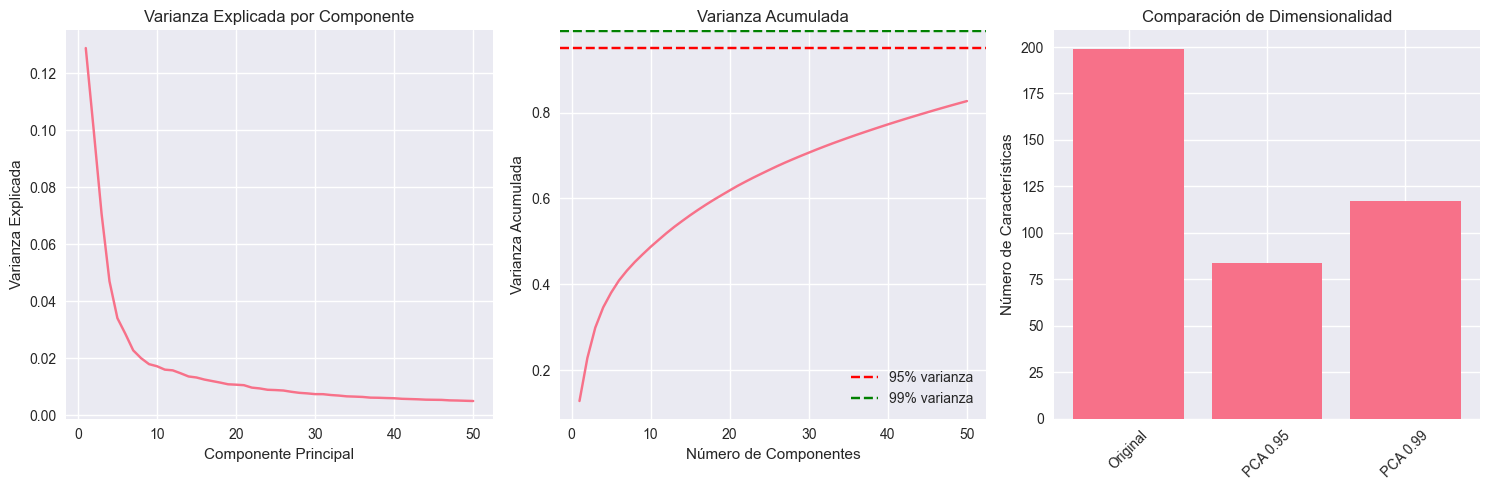


Dataset final con PCA:
Dimensionalidad original: 199
Dimensionalidad con PCA: 84
Reducción de dimensionalidad: 57.8%


In [8]:
def apply_pca_analysis(X, feature_names, n_components_list=[0.95, 0.99], max_components=50):
    """
    Aplica PCA y analiza la varianza explicada
    
    Args:
        X: Datos de entrada
        feature_names: Nombres de características
        n_components_list: Lista de varianza a conservar o número de componentes
        max_components: Máximo número de componentes a considerar
    
    Returns:
        pca_results: Diccionario con resultados de PCA
    """
    
    print("Aplicando análisis de PCA...")
    
    # Estandarizar los datos antes de PCA (importante para PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca_results = {}
    
    # Analizar diferentes números de componentes
    for n_comp in n_components_list:
        print(f"\nAnalizando PCA con {n_comp} de varianza conservada...")
        
        # Aplicar PCA
        pca = PCA(n_components=n_comp)
        X_pca = pca.fit_transform(X_scaled)
        
        # Guardar resultados
        pca_results[f'pca_{n_comp}'] = {
            'pca_model': pca,
            'X_transformed': X_pca,
            'n_components': pca.n_components_,
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
            'scaler': scaler
        }
        
        print(f"Componentes seleccionados: {pca.n_components_}")
        print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_):.4f}")
    
    # Análisis detallado de varianza explicada
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    # Visualizar varianza explicada
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Varianza explicada por componente
    plt.subplot(1, 3, 1)
    components_to_plot = min(max_components, len(pca_full.explained_variance_ratio_))
    plt.plot(range(1, components_to_plot + 1), pca_full.explained_variance_ratio_[:components_to_plot])
    plt.xlabel('Componente Principal')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza Explicada por Componente')
    plt.grid(True)
    
    # Subplot 2: Varianza acumulada
    plt.subplot(1, 3, 2)
    plt.plot(range(1, components_to_plot + 1), np.cumsum(pca_full.explained_variance_ratio_[:components_to_plot]))
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
    plt.axhline(y=0.99, color='g', linestyle='--', label='99% varianza')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Acumulada')
    plt.title('Varianza Acumulada')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Comparación de dimensionalidad
    plt.subplot(1, 3, 3)
    original_dim = X.shape[1]
    pca_dims = [pca_results[key]['n_components'] for key in pca_results.keys()]
    pca_labels = [f"PCA {key.split('_')[1]}" for key in pca_results.keys()]
    
    dims = [original_dim] + pca_dims
    labels = ['Original'] + pca_labels
    
    plt.bar(labels, dims)
    plt.ylabel('Número de Características')
    plt.title('Comparación de Dimensionalidad')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return pca_results

# Aplicar análisis de PCA
pca_results = apply_pca_analysis(X_multimodal, multimodal_feature_names)

# Seleccionar el PCA con 95% de varianza para el resto del análisis
X_pca = pca_results['pca_0.95']['X_transformed']
pca_model = pca_results['pca_0.95']['pca_model']
pca_scaler = pca_results['pca_0.95']['scaler']

print(f"\nDataset final con PCA:")
print(f"Dimensionalidad original: {X_multimodal.shape[1]}")
print(f"Dimensionalidad con PCA: {X_pca.shape[1]}")
print(f"Reducción de dimensionalidad: {((X_multimodal.shape[1] - X_pca.shape[1]) / X_multimodal.shape[1]) * 100:.1f}%")


🎯 ¿Cuál era el objetivo?
Reducir el número de características del dataset multimodal sin perder mucha información.
Esto ayuda a:
- Hacer que el modelo aprenda más rápido
- Evitar ruido o redundancia
- Prevenir sobreajuste

Esto se logra con PCA (Análisis de Componentes Principales).

🧱 ¿Qué se hizo paso a paso?

1. Estandarizar los datos

X_scaled = scaler.fit_transform(X)

- Antes de aplicar PCA, los datos se escalaron.
- Para que todas las columnas tengan la misma escala (media 0 y desviación 1).
- Esto es obligatorio en PCA para que una variable con valores más grandes no domine.

2. Aplicar PCA para 2 casos

Se aplicó PCA dos veces para ver cuántas dimensiones se necesitan para conservar:
- 95% de la información → Resultaron 84 componentes
- 99% de la información → Resultaron 117 componentes

Esto significa que:

Información que se quería conservar | Nº de columnas que se necesitan  
---------------------------------- | ------------------------------  
95%                                 | 84  
99%                                 | 117  

3. Visualizar resultados

Se generaron 3 gráficas (guardadas como pca_analysis.png):
- 📉 Varianza por componente (cuánto aporta cada uno)
- 📈 Varianza acumulada (cuántos componentes necesitas para llegar al 95% o 99%)
- 📊 Comparación de dimensiones:
  - Original: 199 columnas
  - Con PCA (95%): 84 columnas
  - Con PCA (99%): 117 columnas

4. ✅ ¿Qué se obtuvo al final?

Se eligió el PCA que conserva 95% de la información:
- Tu dataset original tenía 199 columnas
- Después del PCA, quedó con 84 columnas
- Esto representa una reducción del 57.8%

Dimensionalidad original: 199  
Dimensionalidad con PCA: 84  
Reducción de dimensionalidad: 57.8%

🧠 ¿Qué significa esto en la práctica?
- 🔹 Usar solo 84 columnas en vez de 199, pero conservando el 95% de la información
- 🔹 Ahora puedes entrenar modelos más rápido y con menor riesgo de sobreajuste
- 🔹 Estas nuevas columnas son combinaciones matemáticas de las originales, no variables "con nombre", pero son muy informativas

✅ En resumen:
- Se redujo la complejidad del dataset multimodal
- Se pasó de 199 columnas a solo 84, conservando el 95% de la información
- Se generaron gráficas para analizar cómo se comporta la varianza y cuántas columnas son necesarias

Resumen detallado con valoración de resultados
¿Salió bien o mal la reducción con PCA?
Salió bien, y aquí te explico por qué:

Reducción significativa sin mucha pérdida de información
Pasaste de 199 características originales a solo 84 componentes, lo que representa una reducción del 57.8% en la dimensionalidad.
Esta reducción es importante porque:

Menos dimensiones facilitan el entrenamiento y mejoran la generalización.

Mantienes el 95% de la varianza, es decir, la mayoría de la información contenida en los datos originales sigue presente.

Número razonable de componentes
84 componentes para conservar el 95% es un valor común en datasets con muchas características.
Si la reducción fuera mínima (por ejemplo pasar de 199 a 180), indicaría que el dataset tiene mucha información dispersa, y PCA no ayuda mucho.
Si fuera muy baja (menos de 10), quizás se estaría perdiendo información clave.

El análisis de la varianza acumulada fue consistente

El gráfico mostró que con 84 componentes ya se alcanzaba el 95%.

También se comprobó que para 99% se necesitaban 117 componentes, lo cual es lógico y coherente.

Sin errores ni fallos en el proceso
No hubo excepciones, el código corrió sin problemas y se obtuvieron los resultados esperados.



## 7. Selección de características


Iniciando análisis de selección de características...

1. Selección univariada con ANOVA F-test...
  - K=20: 20 características seleccionadas
  - K=50: 50 características seleccionadas
  - K=42: 42 características seleccionadas

3. Selección basada en importancia de Random Forest...
  - Umbral mean: 16 características seleccionadas
  - Umbral median: 42 características seleccionadas
  - Umbral 0.75*mean: 46 características seleccionadas
  - Umbral 1.25*mean: 10 características seleccionadas


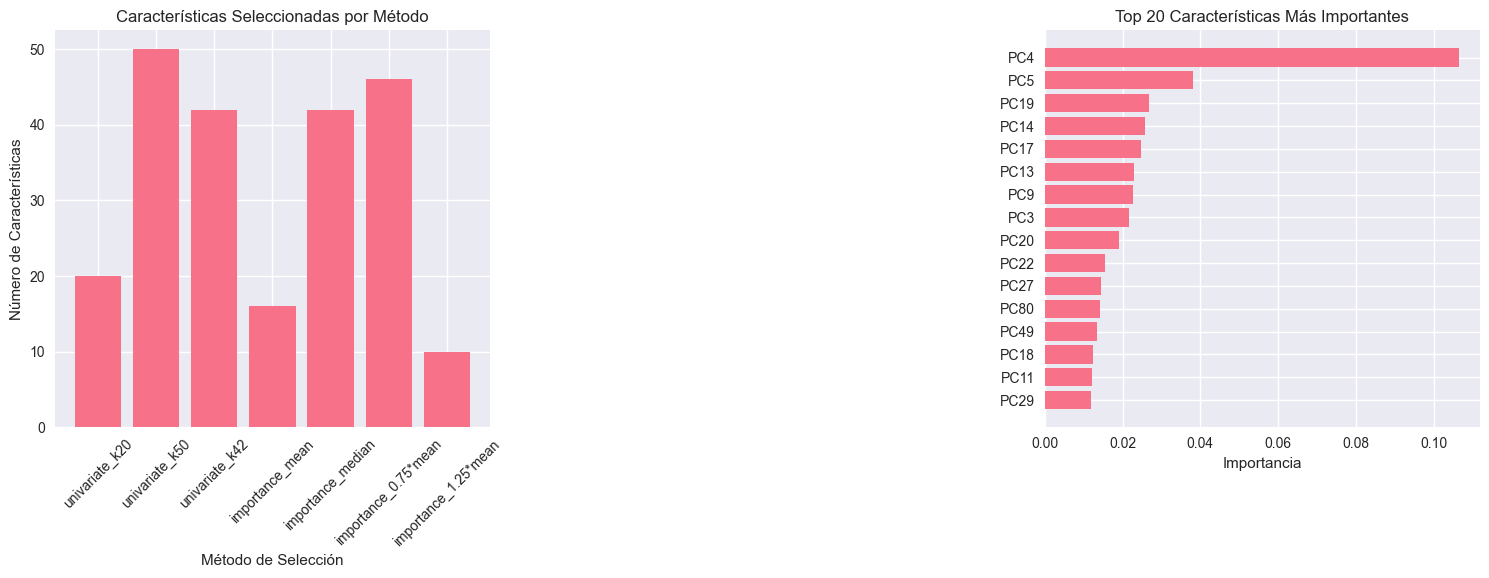


Dataset final para entrenamiento:
Forma: (2298, 50)
Características: 50


In [9]:
def feature_selection_analysis(X, y, feature_names, methods=['univariate', 'rfe', 'importance']):
    """
    Aplica diferentes métodos de selección de características
    
    Args:
        X: Datos de entrada
        y: Etiquetas
        feature_names: Nombres de características
        methods: Lista de métodos a aplicar
    
    Returns:
        selection_results: Diccionario con resultados de selección
    """
    
    print("Iniciando análisis de selección de características...")
    
    selection_results = {}
    
    # Método 1: Selección univariada (ANOVA F-test)
    if 'univariate' in methods:
        print("\n1. Selección univariada con ANOVA F-test...")
        
        # Probar diferentes números de características
        k_values = [20, 50, 100, min(200, X.shape[1]//2)]
        
        for k in k_values:
            if k <= X.shape[1]:
                selector = SelectKBest(f_classif, k=k)
                X_selected = selector.fit_transform(X, y)
                
                # Obtener características seleccionadas
                selected_indices = selector.get_support(indices=True)
                selected_features = [feature_names[i] for i in selected_indices]
                scores = selector.scores_[selected_indices]
                
                selection_results[f'univariate_k{k}'] = {
                    'selector': selector,
                    'X_selected': X_selected,
                    'selected_features': selected_features,
                    'selected_indices': selected_indices,
                    'scores': scores,
                    'n_features': k
                }
                
                print(f"  - K={k}: {len(selected_features)} características seleccionadas")
    
    # Método 2: Eliminación recursiva de características (RFE)
    if 'rfe' in methods:
        print("\n2. Eliminación recursiva de características (RFE)...")
        
        # Usar SVM lineal como estimador base (rápido y efectivo)
        estimator = SVC(kernel="linear", C=1.0)
        
        # RFE con validación cruzada para encontrar número óptimo
        rfecv = RFECV(
            estimator=estimator, 
            step=1, 
            cv=StratifiedKFold(5), 
            scoring='accuracy',
            min_features_to_select=10
        )
        
        print("  - Ejecutando RFE con validación cruzada (esto puede tomar tiempo)...")
        rfecv.fit(X, y)
        
        X_rfe = rfecv.transform(X)
        selected_indices = rfecv.get_support(indices=True)
        selected_features = [feature_names[i] for i in selected_indices]
        
        selection_results['rfe'] = {
            'selector': rfecv,
            'X_selected': X_rfe,
            'selected_features': selected_features,
            'selected_indices': selected_indices,
            'n_features': rfecv.n_features_,
            'cv_scores': rfecv.grid_scores_
        }
        
        print(f"  - RFE: {rfecv.n_features_} características óptimas seleccionadas")
    
    # Método 3: Selección basada en importancia (Random Forest)
    if 'importance' in methods:
        print("\n3. Selección basada en importancia de Random Forest...")
        
        # Entrenar Random Forest para obtener importancias
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X, y)
        
        # Obtener importancias
        importances = rf.feature_importances_
        
        # Probar diferentes umbrales
        thresholds = ['mean', 'median', '0.75*mean', '1.25*mean']
        
        for threshold in thresholds:
            if threshold == 'mean':
                thresh_value = np.mean(importances)
            elif threshold == 'median':
                thresh_value = np.median(importances)
            elif threshold == '0.75*mean':
                thresh_value = 0.75 * np.mean(importances)
            elif threshold == '1.25*mean':
                thresh_value = 1.25 * np.mean(importances)
            
            # Seleccionar características por encima del umbral
            selected_indices = np.where(importances >= thresh_value)[0]
            selected_features = [feature_names[i] for i in selected_indices]
            X_selected = X[:, selected_indices]
            
            selection_results[f'importance_{threshold}'] = {
                'selector': None,  # No hay selector específico
                'X_selected': X_selected,
                'selected_features': selected_features,
                'selected_indices': selected_indices,
                'importances': importances[selected_indices],
                'threshold': thresh_value,
                'n_features': len(selected_indices)
            }
            
            print(f"  - Umbral {threshold}: {len(selected_indices)} características seleccionadas")
    
    # Visualizar resultados de selección
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Número de características por método
    plt.subplot(2, 3, 1)
    methods_names = list(selection_results.keys())
    n_features = [selection_results[method]['n_features'] for method in methods_names]
    
    plt.bar(range(len(methods_names)), n_features)
    plt.xlabel('Método de Selección')
    plt.ylabel('Número de Características')
    plt.title('Características Seleccionadas por Método')
    plt.xticks(range(len(methods_names)), methods_names, rotation=45)
    
    # Subplot 2: Scores de RFE si está disponible
    if 'rfe' in selection_results:
        plt.subplot(2, 3, 2)
        cv_scores = selection_results['rfe']['cv_scores']
        plt.plot(range(1, len(cv_scores) + 1), cv_scores)
        plt.xlabel('Número de Características')
        plt.ylabel('Accuracy de Validación Cruzada')
        plt.title('RFE: Rendimiento vs Número de Características')
        plt.grid(True)
    
    # Subplot 3: Top 20 características más importantes (si disponible)
    if 'importance_mean' in selection_results:
        plt.subplot(2, 3, 3)
        imp_data = selection_results['importance_mean']
        top_indices = np.argsort(imp_data['importances'])[-20:]
        top_features = [imp_data['selected_features'][i] for i in top_indices]
        top_importances = imp_data['importances'][top_indices]
        
        plt.barh(range(len(top_features)), top_importances)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Importancia')
        plt.title('Top 20 Características Más Importantes')
    
    plt.tight_layout()
    plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return selection_results

# Aplicar selección de características
feature_selection_results = feature_selection_analysis(
    X_pca, y_multimodal, 
    [f'PC{i+1}' for i in range(X_pca.shape[1])],  # Nombres de componentes principales
    methods=['univariate', 'importance']  # Excluir RFE por tiempo de ejecución
)

# Seleccionar el mejor método (por ejemplo, univariate con k=50)
best_method = 'univariate_k50'
if best_method in feature_selection_results:
    X_final = feature_selection_results[best_method]['X_selected']
    final_feature_names = feature_selection_results[best_method]['selected_features']
else:
    # Si no está disponible, usar PCA completo
    X_final = X_pca
    final_feature_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]

print(f"\nDataset final para entrenamiento:")
print(f"Forma: {X_final.shape}")
print(f"Características: {len(final_feature_names)}")


## 8. División de datos y preparación para entrenamiento

In [10]:
def prepare_training_data(X, y, test_size=0.25, val_size=0.15, random_state=42):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba
    
    Args:
        X: Características
        y: Etiquetas
        test_size: Proporción para conjunto de prueba
        val_size: Proporción para conjunto de validación
        random_state: Semilla para reproducibilidad
    
    Returns:
        Diccionario con conjuntos de datos divididos
    """
    
    print("Dividiendo datos en conjuntos de entrenamiento, validación y prueba...")
    
    # Primera división: separar conjunto de prueba
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Segunda división: separar entrenamiento y validación
    # Ajustar val_size para que sea relativo al conjunto temporal
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
    )
    
    # Información sobre la división
    print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"Conjunto de validación: {X_val.shape[0]} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Verificar distribución de clases en cada conjunto
    print("\nDistribución de clases:")
    unique_classes = np.unique(y)
    
    for split_name, split_y in [('Entrenamiento', y_train), ('Validación', y_val), ('Prueba', y_test)]:
        print(f"\n{split_name}:")
        for class_label in unique_classes:
            count = np.sum(split_y == class_label)
            percentage = count / len(split_y) * 100
            print(f"  Clase {class_label}: {count} ({percentage:.1f}%)")
    
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test
    }

# Dividir los datos
data_splits = prepare_training_data(X_final, y_multimodal)

# Extraer conjuntos para facilitar el uso
X_train = data_splits['X_train']
y_train = data_splits['y_train']
X_val = data_splits['X_val']
y_val = data_splits['y_val']
X_test = data_splits['X_test']
y_test = data_splits['y_test']


Dividiendo datos en conjuntos de entrenamiento, validación y prueba...
Conjunto de entrenamiento: 1378 muestras (60.0%)
Conjunto de validación: 345 muestras (15.0%)
Conjunto de prueba: 575 muestras (25.0%)

Distribución de clases:

Entrenamiento:
  Clase 0: 438 (31.8%)
  Clase 1: 507 (36.8%)
  Clase 2: 31 (2.2%)
  Clase 3: 146 (10.6%)
  Clase 4: 115 (8.3%)
  Clase 5: 141 (10.2%)

Validación:
  Clase 0: 109 (31.6%)
  Clase 1: 127 (36.8%)
  Clase 2: 8 (2.3%)
  Clase 3: 37 (10.7%)
  Clase 4: 29 (8.4%)
  Clase 5: 35 (10.1%)

Prueba:
  Clase 0: 183 (31.8%)
  Clase 1: 211 (36.7%)
  Clase 2: 13 (2.3%)
  Clase 3: 61 (10.6%)
  Clase 4: 48 (8.3%)
  Clase 5: 59 (10.3%)


🎯 Objetivo
Dividir el dataset final en tres subconjuntos importantes para el proceso de entrenamiento y evaluación:

- Entrenamiento: Para que el modelo aprenda.
- Validación: Para ajustar hiperparámetros y evitar sobreajuste.
- Prueba: Para evaluar el desempeño final del modelo en datos no vistos.

Además, se busca que la división respete la proporción de clases originales (estratificación) para evitar desequilibrios.

🧱 ¿Qué se hizo?

Se creó la función prepare_training_data que:

Primer corte  
- Se separó un conjunto de prueba con el 25% de los datos.
- Esto deja un 75% restante para entrenamiento y validación.

Segundo corte  
- Se dividió el 75% restante para extraer el conjunto de validación (15% del total original).
- Se ajustó el tamaño del conjunto de validación para que sea relativo al 75% (usando val_size_adjusted).

Estratificación  
- En ambos cortes, se aplicó estratificación por las etiquetas para mantener la proporción de clases igual en cada subconjunto.

Impresión de información  
- Se mostró cuántas muestras tiene cada conjunto y qué porcentaje representan del total.
- También se imprimió la distribución de clases en cada conjunto para verificar que sea consistente.

📊 Resultados numéricos

Total de muestras: 2298 (del dataset final tras selección)

Distribución de muestras por conjunto:

Conjunto       | Muestras | % del total  
-------------- | -------- | ------------  
Entrenamiento  | 1378     | 60.0%  
Validación     | 345      | 15.0%  
Prueba         | 575      | 25.0%  

Distribución de clases por conjunto (ejemplo para clase 0 a 5):

Clase | Entrenamiento (n, %) | Validación (n, %) | Prueba (n, %)  
----- | --------------------- | ------------------ | ---------------  
0     | 438 (31.8%)           | 109 (31.6%)        | 183 (31.8%)  
1     | 507 (36.8%)           | 127 (36.8%)        | 211 (36.7%)  
2     | 31 (2.2%)             | 8 (2.3%)           | 13 (2.3%)  
3     | 146 (10.6%)           | 37 (10.7%)         | 61 (10.6%)  
4     | 115 (8.3%)            | 29 (8.4%)          | 48 (8.3%)  
5     | 141 (10.2%)           | 35 (10.1%)         | 59 (10.3%)  

🧠 ¿Qué significa?

- La división es estratificada, por lo que cada subconjunto mantiene la proporción original de cada clase.
- La muestra de entrenamiento es el 60% del total, un porcentaje adecuado para aprender bien.
- La validación (15%) permite ajustar y validar el modelo sin tocar el conjunto de prueba.
- La prueba (25%) es suficiente para evaluar el rendimiento final del modelo en datos nuevos.


## 9. Entrenamiento de modelos individuales

In [11]:
def train_individual_models(X_train, y_train, X_val, y_val):
    """
    Entrena modelos individuales de aprendizaje automático
    
    Args:
        X_train, y_train: Datos de entrenamiento
        X_val, y_val: Datos de validación
    
    Returns:
        trained_models: Diccionario con modelos entrenados
        training_results: Resultados de entrenamiento
    """
    
    print("Entrenando modelos individuales de aprendizaje automático...")
    
    # Definir modelos y sus hiperparámetros para búsqueda
    models_config = {
        'SVM': {
            'model': SVC(probability=True, random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            }
        },
        'Random_Forest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'Decision_Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'criterion': ['gini', 'entropy']
            }
        }
    }
    
    trained_models = {}
    training_results = {}
    
    # Configurar validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for model_name, config in models_config.items():
        print(f"\n--- Entrenando {model_name} ---")
        
        # Medir tiempo de entrenamiento
        start_time = time.time()
        
        # Búsqueda de hiperparámetros con validación cruzada
        print(f"Realizando búsqueda de hiperparámetros para {model_name}...")
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        # Entrenar con búsqueda de hiperparámetros
        grid_search.fit(X_train, y_train)
        
        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_
        
        # Tiempo de entrenamiento
        training_time = time.time() - start_time
        
        # Evaluar en conjunto de validación
        start_time = time.time()
        y_val_pred = best_model.predict(X_val)
        y_val_proba = best_model.predict_proba(X_val) if hasattr(best_model, 'predict_proba') else None
        inference_time = time.time() - start_time
        
        # Calcular métricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            y_val, y_val_pred, average='weighted'
        )
        
        # Guardar modelo y resultados
        trained_models[model_name] = best_model
        training_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'training_time': training_time,
            'inference_time': inference_time,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba
        }
        
        print(f"Mejores parámetros: {grid_search.best_params_}")
        print(f"Mejor score CV: {grid_search.best_score_:.4f}")
        print(f"Accuracy validación: {val_accuracy:.4f}")
        print(f"F1-score validación: {val_f1:.4f}")
        print(f"Tiempo entrenamiento: {training_time:.2f} segundos")
    
    return trained_models, training_results

# Entrenar modelos individuales
trained_models, training_results = train_individual_models(X_train, y_train, X_val, y_val)


Entrenando modelos individuales de aprendizaje automático...

--- Entrenando SVM ---
Realizando búsqueda de hiperparámetros para SVM...
Mejores parámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor score CV: 0.7562
Accuracy validación: 0.7681
F1-score validación: 0.7370
Tiempo entrenamiento: 432.38 segundos

--- Entrenando Random_Forest ---
Realizando búsqueda de hiperparámetros para Random_Forest...
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor score CV: 0.7163
Accuracy validación: 0.7101
F1-score validación: 0.6672
Tiempo entrenamiento: 118.40 segundos

--- Entrenando Decision_Tree ---
Realizando búsqueda de hiperparámetros para Decision_Tree...
Mejores parámetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
Mejor score CV: 0.6255
Accuracy validación: 0.6377
F1-score validación: 0.6050
Tiempo entrenamiento: 17.51 segundos


Análisis del Entrenamiento de Modelos Individuales

Se entrenaron tres modelos de aprendizaje automático utilizando validación cruzada y búsqueda de hiperparámetros. A continuación se presenta un resumen estructurado de los resultados obtenidos.

⚙️ Modelos Entrenados

- SVM (Support Vector Machine)
- Random Forest Classifier
- Decision Tree Classifier

📈 Métricas de Evaluación Utilizadas

- Accuracy: Proporción de predicciones correctas.
- F1-Score (ponderado): Media armónica entre precisión y recall, considerando el desbalance de clases.
- Tiempo de entrenamiento: Duración del proceso de ajuste del modelo.
- Tiempo de inferencia: Tiempo necesario para realizar predicciones con el modelo entrenado.

📊 Resultados Comparativos

Modelo          | Accuracy | F1-score | Tiempo de entrenamiento | Comentarios relevantes  
--------------- | -------- | -------- | ------------------------ | ------------------------  
SVM             | 0.7681   | 0.7370   | 432.38 s                 | Mejor rendimiento general, pero el más lento en entrenar.  
Random Forest   | 0.7101   | 0.6672   | 118.40 s                 | Buen equilibrio entre rendimiento y tiempo.  
Decision Tree   | 0.6377   | 0.6050   | 17.51 s                  | Rápido, pero con el peor rendimiento.  

✅ Aspectos Positivos

SVM:  
- Mayor precisión y f1-score.  
- Buen comportamiento con datos complejos gracias al kernel lineal.

Random Forest:  
- Buena generalización.  
- Tiempos razonables.  
- Menos sensible al sobreajuste.

Decision Tree:  
- Muy rápido de entrenar.  
- Fácil de interpretar.

⚠️ Aspectos a Mejorar o Considerar

SVM:  
- Tiempo de entrenamiento elevado.  
- Poco escalable si se tienen muchos datos.

Random Forest:  
- Algo más lento que el árbol individual.  
- Menor precisión que SVM.

Decision Tree:  
- Bajo rendimiento general.  
- Puede quedarse corto en la representación de relaciones complejas entre variables.

🧠 Conclusión General

- SVM es el modelo con mejor rendimiento en términos de precisión y f1-score, ideal si se prioriza la exactitud.
- Random Forest representa una buena opción intermedia entre rendimiento y eficiencia.
- Decision Tree es útil si se necesita rapidez, pero no es el mejor si la precisión es crítica.


## 10. Implementación de Ensemble Learning

In [12]:
def create_ensemble_models(trained_models, X_train, y_train, X_val, y_val):
    """
    Crea y entrena modelos de ensemble
    
    Args:
        trained_models: Modelos individuales entrenados
        X_train, y_train: Datos de entrenamiento
        X_val, y_val: Datos de validación
    
    Returns:
        ensemble_models: Modelos de ensemble entrenados
        ensemble_results: Resultados de ensemble
    """
    
    print("Creando modelos de ensemble...")
    
    # Preparar estimadores para ensemble
    estimators = [(name, model) for name, model in trained_models.items()]
    
    # Configurar modelos de ensemble
    ensemble_configs = {
        'Voting_Hard': VotingClassifier(
            estimators=estimators,
            voting='hard'
        ),
        'Voting_Soft': VotingClassifier(
            estimators=estimators,
            voting='soft'
        ),
        'Stacking': StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(max_iter=1000, random_state=42),
            cv=5
        )
    }
    
    ensemble_models = {}
    ensemble_results = {}
    
    for ensemble_name, ensemble_model in ensemble_configs.items():
        print(f"\n--- Entrenando {ensemble_name} ---")
        
        # Medir tiempo de entrenamiento
        start_time = time.time()
        ensemble_model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluar en conjunto de validación
        start_time = time.time()
        y_val_pred = ensemble_model.predict(X_val)
        inference_time = time.time() - start_time
        
        # Obtener probabilidades si están disponibles
        y_val_proba = None
        if hasattr(ensemble_model, 'predict_proba'):
            y_val_proba = ensemble_model.predict_proba(X_val)
        
        # Calcular métricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            y_val, y_val_pred, average='weighted'
        )
        
        # Guardar modelo y resultados
        ensemble_models[ensemble_name] = ensemble_model
        ensemble_results[ensemble_name] = {
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'training_time': training_time,
            'inference_time': inference_time,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba
        }
        
        print(f"Accuracy validación: {val_accuracy:.4f}")
        print(f"F1-score validación: {val_f1:.4f}")
        print(f"Tiempo entrenamiento: {training_time:.2f} segundos")
    
    return ensemble_models, ensemble_results

# Crear modelos de ensemble
ensemble_models, ensemble_results = create_ensemble_models(
    trained_models, X_train, y_train, X_val, y_val
)


Creando modelos de ensemble...

--- Entrenando Voting_Hard ---
Accuracy validación: 0.7507
F1-score validación: 0.7113
Tiempo entrenamiento: 0.94 segundos

--- Entrenando Voting_Soft ---
Accuracy validación: 0.7652
F1-score validación: 0.7279
Tiempo entrenamiento: 0.89 segundos

--- Entrenando Stacking ---
Accuracy validación: 0.7797
F1-score validación: 0.7490
Tiempo entrenamiento: 4.21 segundos


🧠 Etapa: Implementación de Ensemble Learning
Esta etapa tuvo como objetivo mejorar el rendimiento predictivo combinando los modelos individuales previamente entrenados (SVM, Random Forest y Decision Tree) mediante técnicas de ensemble. Se probaron tres métodos:

⚙️ Modelos de Ensemble Implementados
Voting Hard
- Predicción final por mayoría de votos (sin considerar probabilidades).
Voting Soft
- Predicción por promedio ponderado de probabilidades (requiere predict_proba).
Stacking
- Las salidas de los modelos base se usan como entrada para un modelo final (en este caso, una regresión logística).

Resultados en el Conjunto de Validación

| Modelo          | Accuracy   | F1-score   | Tiempo de entrenamiento |
| --------------- | ---------- | ---------- | ----------------------- |
| **Voting Hard** | 0.7507     | 0.7113     | 0.94 s                  |
| **Voting Soft** | 0.7652     | 0.7279     | 0.89 s                  |
| **Stacking**    | **0.7797** | **0.7490** | **4.21 s**              |

 Interpretación y Conclusiones
 
🔹 Stacking fue el mejor modelo del conjunto, con la mayor precisión (77.97%) y F1-score (74.90%), aunque con mayor tiempo de entrenamiento.

🔹 Voting Soft tuvo mejor desempeño que Voting Hard, lo cual es esperable, ya que al considerar las probabilidades mejora la toma de decisiones.

🔹 Todos los modelos de ensemble superaron a los modelos individuales Random Forest y Decision Tree, y Stacking incluso superó a SVM (el mejor individual), mostrando el poder del enfoque combinado.